# 프로젝트명 : 인물 모드 사진 만들기

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

## 1. 인물사진 모드 개요 

### 1) 셸로우 포커스 만들기 프로세스
- 배경이 있는 셀카를 촬영합니다. (배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)
- 시멘틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리합니다.
- 블러링(blurring) 기술로 배경을 흐리게 합니다.
- 피사체를 배경의 원래 위치에 합성합니다.

### 2) 이미지 세그멘테이션 이해

인물사진 모드, 즉 __이미지에서 인물을 제외한 나머지 배경의 흐름 효과를 주기 위해서는 사람과 다른 배경들을 먼저 분리해야 한다.__   
이는 포토샵의 __'누끼 따기' 작업__ 을 생각하면 이해가 쉬울 것이다.

- __세그멘테이션(Segmentation)__  
  
이미지에서 __픽셀 단위로 우리가 원하는 객체를 추출__ 하는 방법을 __이미지 세그멘테이션(image segmentation)__ 이라고 합니다.  
이미지 세그멘테이션은 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정합니다.  
이때 공통 특징은 물리적 의미가 없을 수도 있습니다. 픽셀이 비슷하게 생겼다는 사실은 인식하지만,   
우리가 아는 것처럼 실제 물체 단위로 인식하지 않을 수 있는 것이죠. 물론 세그멘테이션에는 여러 가지 세부 태스크가 있으며,  
태스크에 따라 다양한 기준으로 객체를 추출합니다.

- __시멘틱 세그멘테이션(Semantic segmentation)__  
  
세그멘테이션 중에서도 특히 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션을 시맨틱 세그멘테이션 이라고 합니다.   
쉽게 설명하면 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법이라고 이해하시면 됩니다.   

- __인스턴스 세그멘테이션(Instance segmentation)__  
  
시맨틱 세그멘테이션은 '사람'이라는 추상적인 정보를 이미지에서 추출해내는 방법입니다. 그래서 사람이 누구인지 관계없이 같은 라벨로 표현이 됩니다.
더 나아가서 인스턴스 세그멘테이션은 사람 개개인별로 다른 라벨을 가지게 합니다. 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하자는 것이 목표입니다.

## 2. 인물사진 모드 (1) 사람

### 사진 준비하기

이미지 크기: (980, 1474, 3)


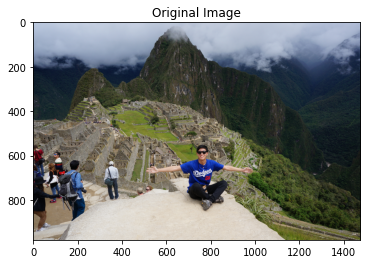

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/exploration/E08/human_segmentation/images/kim01.png'  # 본인이 사용할 사진의 경로
img_orig = cv2.imread(img_path)
print("이미지 크기:", img_orig.shape)

img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title('Original Image')

plt.show()

### 시멘틱 세그멘테이션(Semantic segmentation) 다뤄보기
세그멘테이션 문제에는 FCN, SegNet, U-Net 등 많은 모델이 사용됩니다.  
오늘은 그중에서 DeepLab이라는 세그멘테이션 모델을 만들고 모델에 이미지를 입력하겠습니다.  
DeepLab 알고리즘(DeepLab v3+)은 세그멘테이션 모델 중에서도 성능이 매우 좋아 최근까지도 많이 사용되고 있습니다.

__DeepLab 모델__

In [3]:
# 구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel 클래스를 만들겠습니다.
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

### 사전에 학습된 가중치(pretrained weight) 불러오기
구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드 하고, DeepLabModel 을 초기화합니다.  
이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전입니다.

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/exploration/E08/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/exploration/E08/human_segmentation/models
model loaded successfully!


In [5]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력합니다.
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

# cv2는 이미지를 HWC(Height, Width, Channel) 순서로 표시한다.
# seg_map.max() : 세그멘테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값)을 뜻

(980, 1474, 3) (341, 513, 3) 15


In [6]:
# DeepLab 에서 제공하는 라벨 종류는 아래와 같습니다.
LABEL_NAMES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 
               'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 
               'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']
len(LABEL_NAMES)

21

### 세그멘테이션 결과

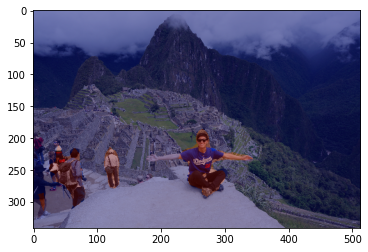

In [7]:
# 사람 라벨을 가진 영역만 검출하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)  # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max())  # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 세그멘테이션 결과를 원래 크기로 복원

DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했습니다. 따라서 출력도 resize 된 입력 크기와 같게 나오게 됩니다.  
세그멘테이션 결과(mask)를 원본 크기로 복원해 보겠습니다.

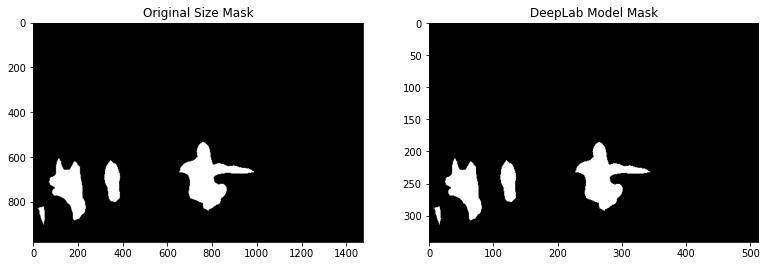

In [8]:
# interpolation(보간법) : 이미지의 크기(scaling)를 변경하는 하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)  

# 결과적으로 img_mask_up은 경계가 블러된 픽셀값 0~255의 이미지를 얻는다.
# 확실한 경계를 다시 정하기 위해 중간값이 128을 기준으로 임계값(threshold)을 설정합니다.
# 128 이하의 값은 0으로, 128 이상의 값은 255로 만들어준다.
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(13,13))

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 배경 흐리게 하기

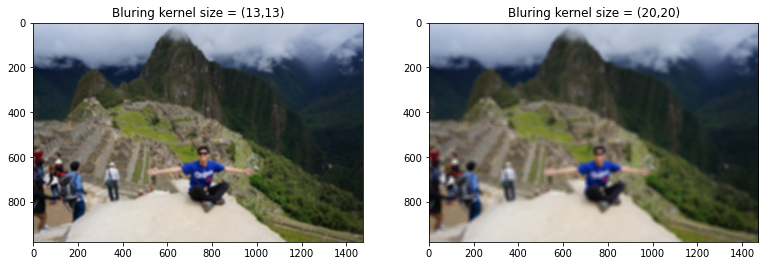

In [9]:
# blur() 함수 이용
img_orig_blur = cv2.blur(img_orig, (13,13))  # (13,13)은 blurring  kernel size를 뜻합니다. 
img_orig_blur2 = cv2.blur(img_orig, (20,20))  # blurring  kernel size를 (20,20)으로 만들어서 (13,13)과 차이를 확인해봅니다. 


plt.figure(figsize=(13,13))

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
ax.set_title('Bluring kernel size = (13,13)')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_orig_blur2, cv2.COLOR_BGR2RGB))
ax.set_title('Bluring kernel size = (20,20)')

plt.show()

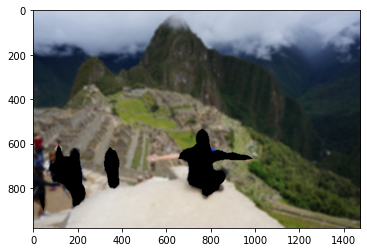

In [10]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)  # bitwise_not 함수를 이용하면 이미지가 반전된다.(배경은 255, 사람은 0)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)  # 반전된 세그멘테이션 결과를 이용해 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있게 된다.

plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))

plt.show()

### 흐린 배경과 원본 영상 합성

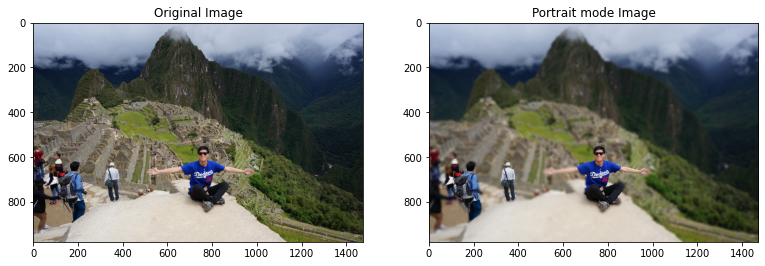

In [11]:
# 배경 이미지와 인물 이미지를 합쳐준다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)  # 마스크에서 255인 부분(사람)은 img_orig, 아닌 부분은 img_bg_blur 를 사용

plt.figure(figsize=(13,13))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('Portrait mode Image')

plt.show()

In [12]:
# 이미지 저장하기
# cv2.imwrite(os.getenv('HOME')+'/aiffel/exploration/E08/human_segmentation/images/new_kim.png', img_concat)

## 3. 인물사진 모드 (2) 고양이

### 사진 준비하기

(512, 512, 3)


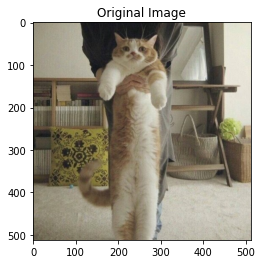

In [13]:
cat_img_path = os.getenv('HOME')+'/aiffel/exploration/E08/human_segmentation/images/cat2.jpg'  # 본인이 사용할 사진의 경로
cat_img_orig = cv2.imread(cat_img_path)
print(cat_img_orig.shape)

cat_img_rgb = cv2.cvtColor(cat_img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(cat_img_rgb)
plt.title('Original Image')
plt.show()

### 세그멘테이션

In [14]:
cat_img_resized, seg_map = MODEL.run(cat_img_orig)
print(cat_img_orig.shape, cat_img_resized.shape, seg_map.max())  

(512, 512, 3) (513, 513, 3) 16


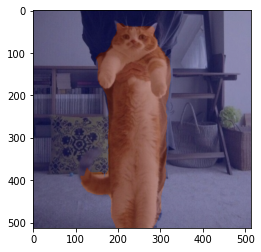

In [15]:
# 고양이만 추출 해보기
img_show = cat_img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0)  # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max())  # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 세그멘테이션 결과를 원래 크기로 복원

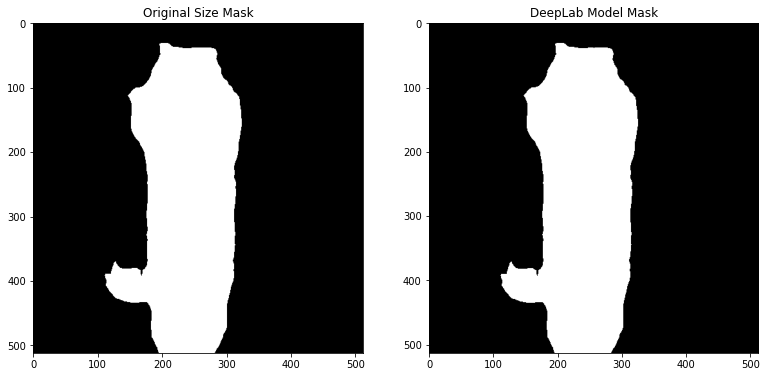

In [16]:
# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, cat_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)  
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(13,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 배경 흐리게 하기

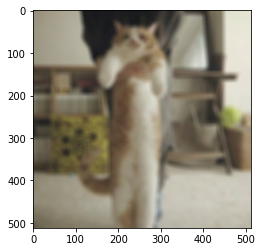

In [17]:
# blur() 함수 이용
cat_img_orig_blur = cv2.blur(cat_img_orig, (13,13))  #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(cat_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

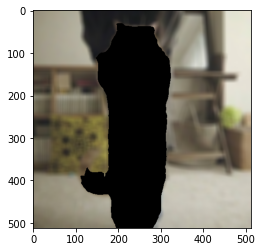

In [18]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(cat_img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐린 배경과 원본 영상 합성

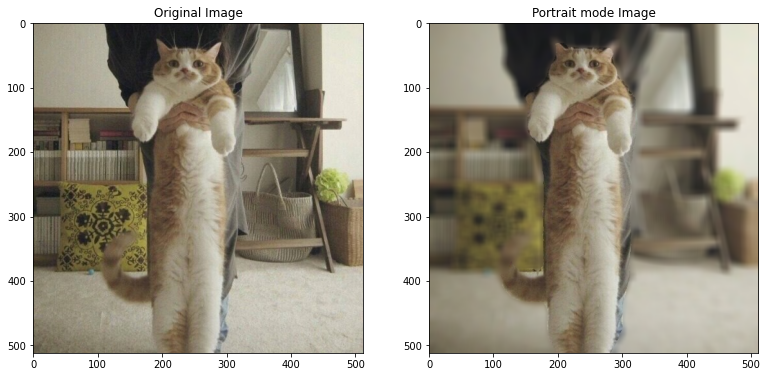

In [19]:
img_concat2 = np.where(img_mask_color==255, cat_img_orig, img_bg_blur)

plt.figure(figsize=(13,13))

plt.subplot(1,2,1)
plt.imshow(cat_img_rgb)
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.title('Portrait mode Image')

plt.show()

## 4. 인물사진 모드 (3) 배경 합성하기

### 사진 준비하기

(608, 1216, 3)


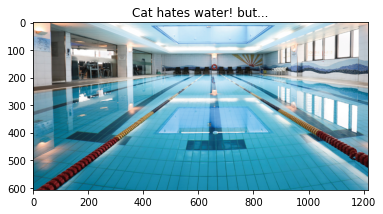

In [20]:
# 배경 이미지
bg_img_path = os.getenv('HOME')+'/aiffel/exploration/E08/human_segmentation/images/background.jpg'  # 본인이 사용할 사진의 경로
bg_img_orig = cv2.imread(bg_img_path)
print(bg_img_orig.shape)

bg_img_rgb = cv2.cvtColor(bg_img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(bg_img_rgb)
plt.title('Cat hates water! but...')
plt.show()

(512, 512, 3)


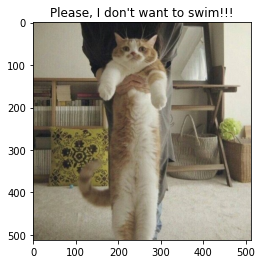

In [21]:
# 고양이 이미지
cat_img_path = os.getenv('HOME')+'/aiffel/exploration/E08/human_segmentation/images/cat2.jpg'  # 본인이 사용할 사진의 경로
cat_img_orig = cv2.imread(cat_img_path)
print(cat_img_orig.shape)

cat_img_rgb = cv2.cvtColor(cat_img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(cat_img_rgb)
plt.title("Please, I don't want to swim!!!")
plt.show()

In [22]:
# 배경 이미지와 고양이 이미지 크기 맞추기
target_size = (cat_img_orig.shape[1], cat_img_orig.shape[0])
bg_resized = cv2.resize(bg_img_orig, target_size)  # 배경 이미지를 target size 크기로 resize 합니다.

### 이미지 합성하기

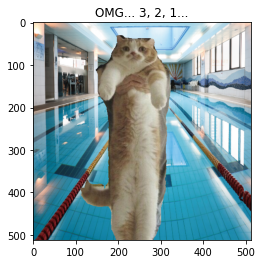

In [23]:
# 배경과 원본 이미지 합성하기
# 앞에서 segementation 작업을 통해 이미 만들어둔 고양이 사진에 수영장 이미지를 합성합니다.

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_concat3 = np.where(img_mask_color==255, cat_img_orig, bg_resized)

plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.title("OMG... 3, 2, 1...")
plt.show()

## 5. 완성된 결과물

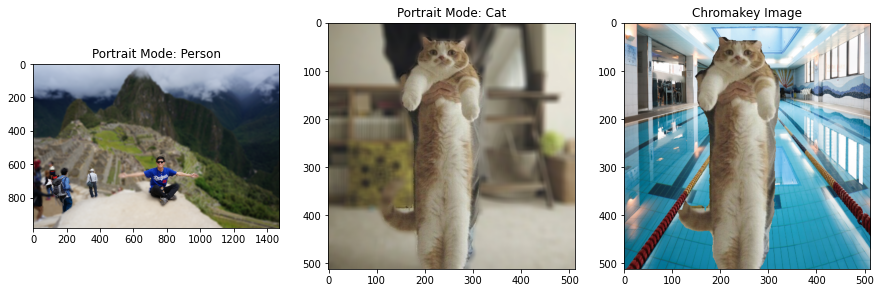

In [24]:
plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('Portrait Mode: Person')

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.title('Portrait Mode: Cat')

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.title('Chromakey Image')

plt.show()

## 6. 문제점

![E09  problem](https://user-images.githubusercontent.com/83560273/129576609-7f56f21e-4e7f-4669-ae69-8168549bb660.png)

## 7. 솔루션

__1) Blur 처리 된 경계선이 깔끔하지 않은 점 → 경계선을 매끄럽게 만들어준다.__
- 피사계 심도를 이용한 보케 효과는 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별하지만, 이를 따라한 시멘틱 세그멘테이션 모듈은 부정확성이 어쩔 수 없이 존재하여 완벽히 구현하기 힘들다.  
  
  
- 인물 사진, 고양이 사진 모두 blur 처리가 깔끔하지 못하고 주변의 배경이 함께 합성되었다.  
  
  
- 경계선에 남아 있는 배경 부분을 따로 확대하여 이 부분을 추가적으로 blur 처리를 한 뒤, 다시 이미지 합성을 하면 좀 더 자연스러운 합성이 될 것 같다. 

__2) 인물 영역에서 팔 부분이 Blur처리 된 부분이 있는 점  → 해결책을 찾지 못하였다.__
- 담당 퍼실님께서도 과거 노드를 진행했을 때 비슷한 현상(상대적으로 얇은 부분은 결과가 제대로 나오지 않음)이 발생하셨다고 하셨다.   
  
  
- 이미지의 화질 문제는 아닐까 생각되어 원본 고화질 이미지를 이용해 아래와 같이 시도 해보았으나 기존과 동일하게 팔 부분을 인식해내지 못하였다. 이 방법은 해결책이 되지 못하는 것 같다.

이미지 크기: (3264, 4912, 3)
(3264, 4912, 3) (340, 513, 3) 15


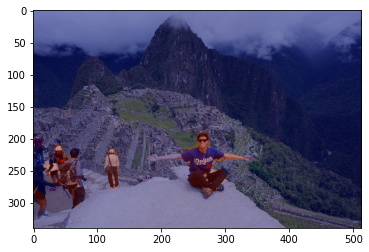

In [25]:
# 고화질 이미지 준비
import os
img_path = os.getenv('HOME')+'/aiffel/exploration/E08/human_segmentation/images/kim03.JPG'  # 본인이 사용할 사진의 경로
img_orig = cv2.imread(img_path)
print("이미지 크기:", img_orig.shape)

# 준비한 이미지를 네트워크에 입력합니다.
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

# 사람 라벨을 가진 영역만 검출하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)  # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max())  # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

__3) Blur처리가 되지 않은 주변 인물 → 인스턴스 세그멘테이션(Instance Segmentation)을 활용해 클래스 구분하기__
- __인스턴스 세그멘테이션__ 은 아래 이미지와 같이 '버스'라는 하나의 추상적인 정보를 이미지에서 추출해내는 시맨틱 세그멘테이션과 달리 __버스 개별적으로 다른 라벨을 가지게 합니다.__   
  
  
- 그러므로 위의 이미지와 같이 여러 사람이 한 이미지에 등장할 때 인스턴스 세그멘테이션을 이용한다면 __각 객체를 분할해서 인식할 수 있을 것 같습니다.__

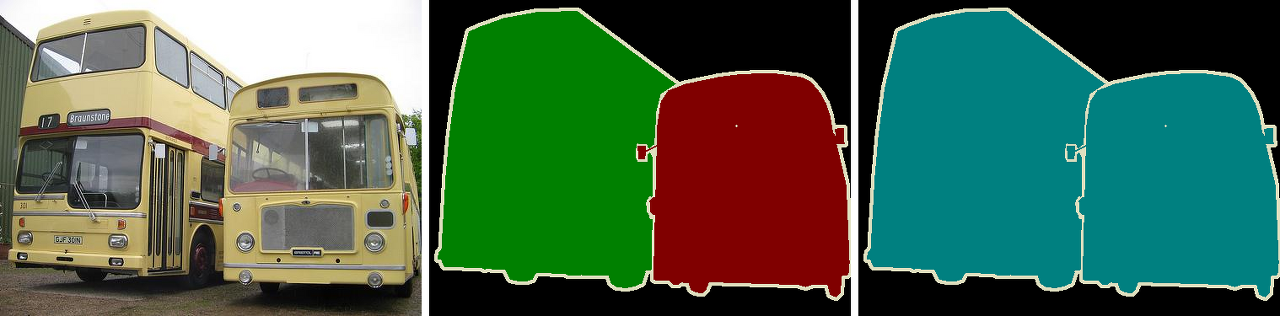
- 좌측 : 원본 이미지, 중간 : instance segmentation, 우측 : semantic segmentation

## 8. 회고

- Segmentation에 대한 개념에 대해서 학습하였는데, 특히 Semantic segmetntaion과 Instance segmentation의 차이를 확실하게 이해할 수 있었다.  
  
  
- DeepLab 모델과 가중치가 주어지지 않았으면 노드를 진행하는데 무척 어려웠을 것 같다. 특히 DeepLab 모델은 코드가 아직도 잘 이해가 안가서 class에 대한 파이썬 복습을 다시 해야될 것 같다.
  

- 노드, 해커톤, 풀잎스쿨 등 반복적인 학습으로 간단한 수준의 데이터 시각화에 있어서는 어느 정도 자신감이 생기는 것 같다.  
  
  
- 시간적 여유가 있을 때 이미지 준비부터 세그멘테이션 결과 실행, 사진 합성까지 일련의 과정을 def 함수로 구현 해보야겠다.